In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(rc={'figure.figsize':(11, 4)})a
sns.set()
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings('ignore')

pd.options.mode.use_inf_as_na = True
pd.options.mode.chained_assignment = None 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

## Load Data
**and have a quick look**

In [2]:
# Load data and look at the basic info
data = pd.read_csv('Eniram Data Engineer Assignment 2019.csv', index_col='Time',  
                   parse_dates=['Time'], infer_datetime_format=True)
data_origin = data.copy(deep=True)
data.head(3)
data.tail(3)
data.info()

# print('\ndata shape: ', data.shape)
# print('\nFeatures:', data.columns.values)
# print('\nFeature type:')
# data.dtypes
# print('\nData time index:')
# data.index

,Stabilizers (boolean),Current (nm/h),Speed (nm/h),Power (MW),Wind speed (m/s),Sea temperature (Celsius),Ship name
Time,,,,,,,
2018-04-25 00:00:00,0.0,0.281,11.019,6.096,12.593,25.57,M/S Albatross
2018-04-25 01:00:00,0.0,0.263,11.137,6.058,14.559,25.60,M/S Albatross
2018-04-25 02:00:00,0.0,0.167,11.133,6.074,10.717,25.65,M/S Albatross


,Stabilizers (boolean),Current (nm/h),Speed (nm/h),Power (MW),Wind speed (m/s),Sea temperature (Celsius),Ship name
Time,,,,,,,
2018-06-24 21:00:00,NaN,-0.171,0.171,0.0,-14.248,NaN,M/S Aurora
2018-06-24 22:00:00,NaN,-0.105,0.105,0.0,-10.638,NaN,M/S Aurora
2018-06-24 23:00:00,NaN,-0.071,0.071,0.0,-2.658,NaN,M/S Aurora


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-04-25 00:00:00 to 2018-06-24 23:00:00
Data columns (total 7 columns):
Stabilizers (boolean)        2928 non-null float64
Current (nm/h)               4392 non-null float64
Speed (nm/h)                 4376 non-null float64
Power (MW)                   4387 non-null float64
Wind speed (m/s)             4392 non-null float64
Sea temperature (Celsius)    2923 non-null float64
Ship name                    4392 non-null object
dtypes: float64(6), object(1)
memory usage: 274.5+ KB


In [3]:
features = data.drop(['Power (MW)','Ship name'],axis=1).columns.values.tolist()
cat_features = ['Stabilizers (boolean)'] 
num_features = [i for i in features if i not in cat_features]
target = 'Power (MW)'

In [4]:
# Check the time interval for each data point
data.index
data.index.to_series().diff().dt.seconds.div(60*60, fill_value=0).unique()

DatetimeIndex(['2018-04-25 00:00:00', '2018-04-25 01:00:00',
               '2018-04-25 02:00:00', '2018-04-25 03:00:00',
               '2018-04-25 04:00:00', '2018-04-25 05:00:00',
               '2018-04-25 06:00:00', '2018-04-25 07:00:00',
               '2018-04-25 08:00:00', '2018-04-25 09:00:00',
               ...
               '2018-06-24 14:00:00', '2018-06-24 15:00:00',
               '2018-06-24 16:00:00', '2018-06-24 17:00:00',
               '2018-06-24 18:00:00', '2018-06-24 19:00:00',
               '2018-06-24 20:00:00', '2018-06-24 21:00:00',
               '2018-06-24 22:00:00', '2018-06-24 23:00:00'],
              dtype='datetime64[ns]', name='Time', length=4392, freq=None)

array([0., 1.])

In [5]:
# length of days
data.index.to_period('D').nunique()

61

In [6]:
# length of weeks
data.index.to_period('W').unique()
data.index.to_period('W').nunique()

PeriodIndex(['2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03',
             '2018-06-04/2018-06-10', '2018-06-11/2018-06-17',
             '2018-06-18/2018-06-24'],
            dtype='period[W-SUN]', name='Time', freq='W-SUN')

9

In [7]:
# Start of the weekday
data.index.weekday_name[0]

'Wednesday'

In [8]:
print('vessels: ', data['Ship name'].unique())
# print('year(s): ', data.index.year.unique().values)
# print('month(s): ', data.index.month.unique().values)

vessels:  ['M/S Albatross' 'M/S Star' 'M/S Aurora']


In [9]:
## Check missing values
data.isna().sum()

Stabilizers (boolean)        1464
Current (nm/h)                  0
Speed (nm/h)                   16
Power (MW)                      5
Wind speed (m/s)                0
Sea temperature (Celsius)    1469
Ship name                       0
dtype: int64

In [10]:
data['day'] = data.index.date
data['week'] = data.index.to_period('W')
data['month'] = data.index.month

### By vessels

In [11]:
group_by_vessel = data.groupby('Ship name',sort=False)
vessel_name = list(group_by_vessel.groups.keys())

In [12]:
for name, group in group_by_vessel:
    print(name)
    group.info()
    print('\nMissing values')
    group.isna().sum()
    # group[group.isnull().any(axis=1)]
    print('*'*80)

M/S Albatross
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 2018-04-25 00:00:00 to 2018-06-24 23:00:00
Data columns (total 10 columns):
Stabilizers (boolean)        1464 non-null float64
Current (nm/h)               1464 non-null float64
Speed (nm/h)                 1449 non-null float64
Power (MW)                   1464 non-null float64
Wind speed (m/s)             1464 non-null float64
Sea temperature (Celsius)    1464 non-null float64
Ship name                    1464 non-null object
day                          1464 non-null object
week                         1464 non-null object
month                        1464 non-null int64
dtypes: float64(6), int64(1), object(3)
memory usage: 125.8+ KB

Missing values


Stabilizers (boolean)         0
Current (nm/h)                0
Speed (nm/h)                 15
Power (MW)                    0
Wind speed (m/s)              0
Sea temperature (Celsius)     0
Ship name                     0
day                           0
week                          0
month                         0
dtype: int64

********************************************************************************
M/S Star
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 2018-04-25 00:00:00 to 2018-06-24 23:00:00
Data columns (total 10 columns):
Stabilizers (boolean)        1464 non-null float64
Current (nm/h)               1464 non-null float64
Speed (nm/h)                 1464 non-null float64
Power (MW)                   1461 non-null float64
Wind speed (m/s)             1464 non-null float64
Sea temperature (Celsius)    1459 non-null float64
Ship name                    1464 non-null object
day                          1464 non-null object
week                         1464 non-null object
month                        1464 non-null int64
dtypes: float64(6), int64(1), object(3)
memory usage: 125.8+ KB

Missing values


Stabilizers (boolean)        0
Current (nm/h)               0
Speed (nm/h)                 0
Power (MW)                   3
Wind speed (m/s)             0
Sea temperature (Celsius)    5
Ship name                    0
day                          0
week                         0
month                        0
dtype: int64

********************************************************************************
M/S Aurora
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 2018-04-25 00:00:00 to 2018-06-24 23:00:00
Data columns (total 10 columns):
Stabilizers (boolean)        0 non-null float64
Current (nm/h)               1464 non-null float64
Speed (nm/h)                 1463 non-null float64
Power (MW)                   1462 non-null float64
Wind speed (m/s)             1464 non-null float64
Sea temperature (Celsius)    0 non-null float64
Ship name                    1464 non-null object
day                          1464 non-null object
week                         1464 non-null object
month                        1464 non-null int64
dtypes: float64(6), int64(1), object(3)
memory usage: 125.8+ KB

Missing values


Stabilizers (boolean)        1464
Current (nm/h)                  0
Speed (nm/h)                    1
Power (MW)                      2
Wind speed (m/s)                0
Sea temperature (Celsius)    1464
Ship name                       0
day                             0
week                            0
month                           0
dtype: int64

********************************************************************************


Albatross misses 15 'Speed' data points

Star misses 3 'Power', 5 'Sea temperature' data points

Aurora has no 'Stabilizers' and 'Sea temperature' data, and misses 1 'Speed', 2'Power' data points

In [13]:
# missing values
vessel1 = data[data['Ship name']==vessel_name[0]]
vessel1.sort_index(inplace=True)
vessel2 = data[data['Ship name']==vessel_name[1]]
vessel2.sort_index(inplace=True)
vessel3 = data[data['Ship name']==vessel_name[2]]
vessel3.sort_index(inplace=True)
print(vessel1['Ship name'][0])
vessel1[vessel1.isnull().any(axis=1)]

print(vessel2['Ship name'][0])
vessel2[vessel2.isnull().any(axis=1)]

print(vessel3['Ship name'][0])
vessel3[vessel3[['Speed (nm/h)','Power (MW)']].isnull().any(axis=1)]

M/S Albatross


,Stabilizers (boolean),Current (nm/h),Speed (nm/h),Power (MW),Wind speed (m/s),Sea temperature (Celsius),Ship name,day,week,month
Time,,,,,,,,,,
2018-05-30 22:00:00,1.0,-0.084,NaN,40.668,5.573,25.110,M/S Albatross,2018-05-30,2018-05-28/2018-06-03,5
2018-05-30 23:00:00,1.0,-0.024,NaN,40.560,2.067,24.700,M/S Albatross,2018-05-30,2018-05-28/2018-06-03,5
2018-05-31 00:00:00,1.0,-0.007,NaN,40.428,1.477,24.780,M/S Albatross,2018-05-31,2018-05-28/2018-06-03,5
2018-05-31 01:00:00,1.0,-0.002,NaN,40.274,1.570,25.280,M/S Albatross,2018-05-31,2018-05-28/2018-06-03,5
2018-05-31 02:00:00,1.0,-0.001,NaN,40.956,0.753,24.960,M/S Albatross,2018-05-31,2018-05-28/2018-06-03,5
2018-05-31 03:00:00,1.0,-0.000,NaN,41.002,1.068,24.990,M/S Albatross,2018-05-31,2018-05-28/2018-06-03,5
2018-05-31 04:00:00,1.0,-0.000,NaN,42.059,-0.638,25.140,M/S Albatross,2018-05-31,2018-05-28/2018-06-03,5
2018-05-31 05:00:00,1.0,-0.000,NaN,42.538,4.362,25.080,M/S Albatross,2018-05-31,2018-05-28/2018-06-03,5
2018-05-31 06:00:00,1.0,-0.000,NaN,42.786,5.447,25.370,M/S Albatross,2018-05-31,2018-05-28/2018-06-03,5


M/S Star


,Stabilizers (boolean),Current (nm/h),Speed (nm/h),Power (MW),Wind speed (m/s),Sea temperature (Celsius),Ship name,day,week,month
Time,,,,,,,,,,
2018-05-09 14:00:00,0.0,-0.058,0.058,NaN,-8.086,32.8,M/S Star,2018-05-09,2018-05-07/2018-05-13,5
2018-05-14 07:00:00,0.0,0.108,18.492,NaN,18.377,NaN,M/S Star,2018-05-14,2018-05-14/2018-05-20,5
2018-05-22 12:00:00,0.0,0.841,10.659,5.534,26.950,NaN,M/S Star,2018-05-22,2018-05-21/2018-05-27,5
2018-05-25 05:00:00,0.0,-0.037,16.037,10.400,11.057,NaN,M/S Star,2018-05-25,2018-05-21/2018-05-27,5
2018-06-08 10:00:00,0.0,-0.049,0.049,0.007,13.636,NaN,M/S Star,2018-06-08,2018-06-04/2018-06-10,6
2018-06-21 16:00:00,0.0,0.007,-0.007,0.006,19.139,NaN,M/S Star,2018-06-21,2018-06-18/2018-06-24,6
2018-06-24 06:00:00,0.0,-1.567,17.067,NaN,44.948,27.2,M/S Star,2018-06-24,2018-06-18/2018-06-24,6


M/S Aurora


,Stabilizers (boolean),Current (nm/h),Speed (nm/h),Power (MW),Wind speed (m/s),Sea temperature (Celsius),Ship name,day,week,month
Time,,,,,,,,,,
2018-05-16 14:00:00,NaN,0.845,0.455,NaN,0.299,NaN,M/S Aurora,2018-05-16,2018-05-14/2018-05-20,5
2018-05-16 15:00:00,NaN,0.891,0.109,NaN,-0.222,NaN,M/S Aurora,2018-05-16,2018-05-14/2018-05-20,5
2018-05-30 15:00:00,NaN,0.015,NaN,0.0,-6.530,NaN,M/S Aurora,2018-05-30,2018-05-28/2018-06-03,5


In [14]:
for i in vessel_name:
    print(i)
    data[data['Ship name']==i][features+[target]].describe()

M/S Albatross


,Stabilizers (boolean),Current (nm/h),Speed (nm/h),Wind speed (m/s),Sea temperature (Celsius),Power (MW)
count,1464.000000,1464.000000,1449.000000,1464.000000,1464.000000,1464.000000
mean,0.252732,-0.033059,11.502973,11.936317,24.572055,17.342557
std,0.434727,0.602521,8.695834,13.277418,3.064892,15.930209
min,0.000000,-3.200000,-0.704000,-19.034000,16.760000,0.000000
25%,0.000000,-0.158000,0.036000,2.080750,22.010000,0.000000
50%,0.000000,0.000000,14.915000,8.786000,24.130000,14.800000
75%,1.000000,0.123000,19.280000,20.742250,27.870000,30.187500
max,1.000000,3.097000,23.407000,70.996000,29.660000,60.314000


M/S Star


,Stabilizers (boolean),Current (nm/h),Speed (nm/h),Wind speed (m/s),Sea temperature (Celsius),Power (MW)
count,1464.000000,1464.000000,1464.000000,1464.000000,1459.000000,1461.000000
mean,0.207650,0.029032,8.278619,10.242529,23.014117,5.014951
std,0.405764,0.479166,6.537714,13.158945,4.285539,4.577051
min,0.000000,-2.969000,-1.372000,-21.736000,13.900000,-0.003000
25%,0.000000,-0.117250,0.048000,0.185750,19.900000,0.007000
50%,0.000000,-0.005000,9.526000,7.888000,22.200000,4.395000
75%,0.000000,0.207000,14.553500,19.308000,25.400000,9.295000
max,1.000000,2.460000,19.666000,49.315000,35.600000,15.851000


M/S Aurora


,Stabilizers (boolean),Current (nm/h),Speed (nm/h),Wind speed (m/s),Sea temperature (Celsius),Power (MW)
count,0.0,1464.000000,1463.000000,1464.000000,0.0,1462.000000
mean,NaN,0.088308,11.703666,11.068172,NaN,10.842746
std,NaN,0.770181,7.189834,12.473395,NaN,8.513485
min,NaN,-2.049000,-1.045000,-16.180000,NaN,0.000000
25%,NaN,-0.303000,4.904500,1.119000,NaN,1.304750
50%,NaN,-0.035000,15.049000,8.293500,NaN,12.527500
75%,NaN,0.316750,17.373500,19.916500,NaN,17.358250
max,NaN,3.607000,20.870000,47.956000,NaN,36.445000


## Exploration

### Power consumption

#### Hourly 

In [15]:
for name, group in group_by_vessel:
    print(name)
    print("Max: {:.3f}MW ({}), Min: {:.3f}MW, Mean: {:.3f}MW (s.d. {:.3f})"
          .format(group['Power (MW)'].max(), group['Power (MW)'].idxmax(),
                  group['Power (MW)'].min(), group['Power (MW)'].mean(), group['Power (MW)'].std()))

M/S Albatross
Max: 60.314MW (2018-04-26 01:00:00), Min: 0.000MW, Mean: 17.343MW (s.d. 15.930)
M/S Star
Max: 15.851MW (2018-06-17 18:00:00), Min: -0.003MW, Mean: 5.015MW (s.d. 4.577)
M/S Aurora
Max: 36.445MW (2018-04-27 14:00:00), Min: 0.000MW, Mean: 10.843MW (s.d. 8.513)


In [16]:
power_hourly = data.pivot(columns='Ship name', values='Power (MW)')

Text(0,0.5,'Power (MW)')

Text(0.2,0.95,'Max power consumption:')

Text(0.2,0.9,'M/S Albatross: 60.314MW (2018-04-26 01:00:00)')

Text(0.2,0.85,'M/S Star: 15.851MW (2018-06-17 18:00:00)')

Text(0.2,0.8,'M/S Aurora: 36.445MW (2018-04-27 14:00:00)')

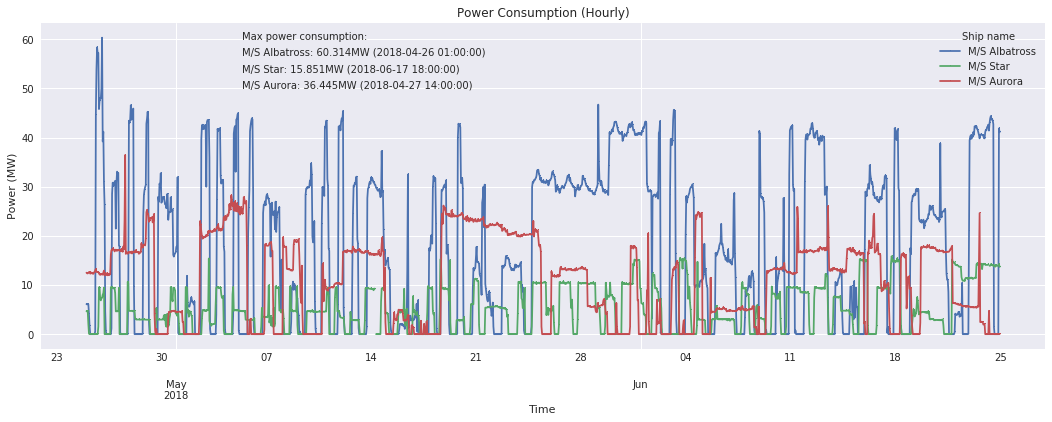

In [17]:
# fig, ax = plt.subplots(figsize=(18,6))

# for name, group in group_by_vessel:
#    group.plot(y='Power (MW)', ax=ax, label=name)

#plt.show()


# fig, ax = plt.subplots(figsize=(16,6))
# for name, group in group_by_vessel:
#    ax.plot(group['Power (MW)'], label=name)
# ax.legend()
# plt.show()

# fig, ax = plt.subplots()
# # group_by_vessel.plot(y='Power (MW)', ax=ax, marker=',',figsize=(16, 5))
# group_by_vessel['Power (MW)'].plot(ax=ax, figsize=(18, 6), legend=True)
# plt.title('Power Consumption (Hourly)')
# plt.ylabel('Power (MW)')
# plt.show()
ax = power_hourly[vessel_name].plot(marker=',', alpha=1.0, 
                               figsize=(18, 6),  title='Power Consumption (Hourly)')
ax.set_ylabel('Power (MW)')
ax.text(0.2,0.95,'Max power consumption:', transform=ax.transAxes)
for i in range(len(vessel_name)):
    ax.text(0.2,0.9-0.05*i,'{}: {:.3f}MW ({})'
            .format(vessel_name[i],power_hourly[vessel_name[i]].max(), 
            power_hourly[vessel_name[i]].idxmax()),
            transform=ax.transAxes)

In [18]:
# axes = power_hourly[vessel_name].plot(marker=',', alpha=1.0, 
#                                figsize=(10, 12), subplots=True, title='Power Consumption')

Text(0.5,1,'Power Consumption Distribtion')

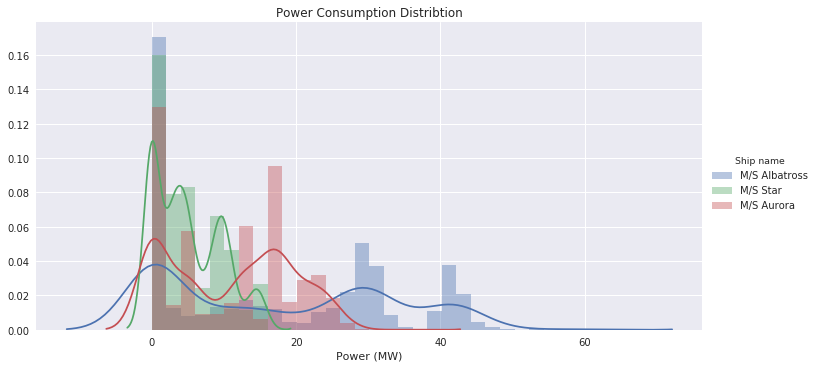

In [19]:
_, bins = np.histogram(data['Power (MW)'].dropna(),bins=30)
plot = sns.FacetGrid(data, hue="Ship name",size=5, aspect=2)
plot = plot.map(sns.distplot, "Power (MW)", bins=bins)
plot.add_legend()
plt.title('Power Consumption Distribtion')

Text(0.5,1,'Boxplot for Power')

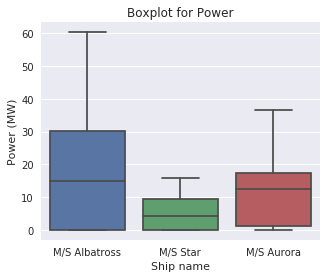

In [20]:
# power_hourly.boxplot(vessel_name)
sns.set(rc={'figure.figsize':(5,4)})
ax = sns.boxplot(data=data,x='Ship name',y='Power (MW)')
ax.set_title('Boxplot for Power')
# ax = sns.swarmplot(x="Ship name", y="Power (MW)", data=data, color=".25")

**As for the mean power consumption over all the hourly data within 61 days, the highest is M/S Albatross,
the loweset is M/S Star.**

**Also, M/s Albatross reached highest power consumption data point, while M/S Star has the lowest.**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aeded21a4e0>,
      dtype=object)

([<matplotlib.axis.XTick at 0x2aeded2ac898>,
 <a list of 13 Text xticklabel objects>)

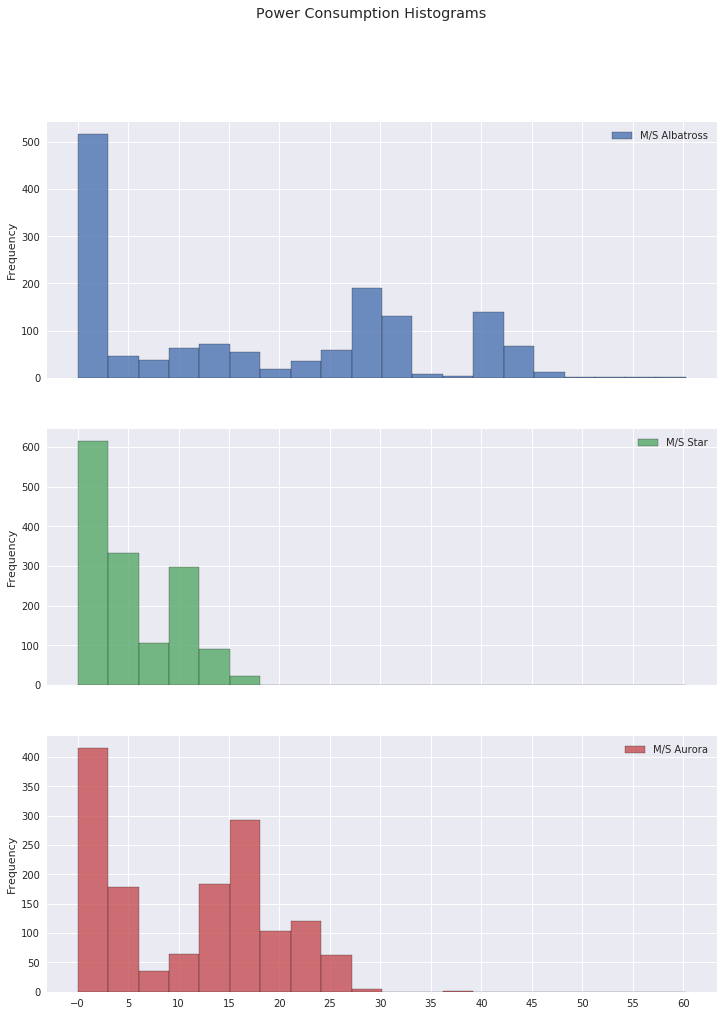

In [21]:
# fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False)
# for (name, group), ax in zip(group_by_vessel, axes.flatten()):
#     group['Power (MW)'].hist(label=name, alpha=.75, bins=20, ax=ax,figsize=(10, 12))

# bins=data['Power (MW)'].quantile(np.linspace(0,1,20,endpoint=True).tolist())
power_hourly[vessel_name].plot(alpha=0.8, figsize=(12, 16), 
                        kind='hist', bins=20, edgecolor='black',
                        subplots=True, title='Power Consumption Histograms')
plt.xticks(np.arange(min(data['Power (MW)']), max(data['Power (MW)'])+1, 5.0))

Text(0.5,0,'Power (MW)')

Text(0,0.5,'Frequency')

Text(0.5,1,'Power Consumption Histogram')

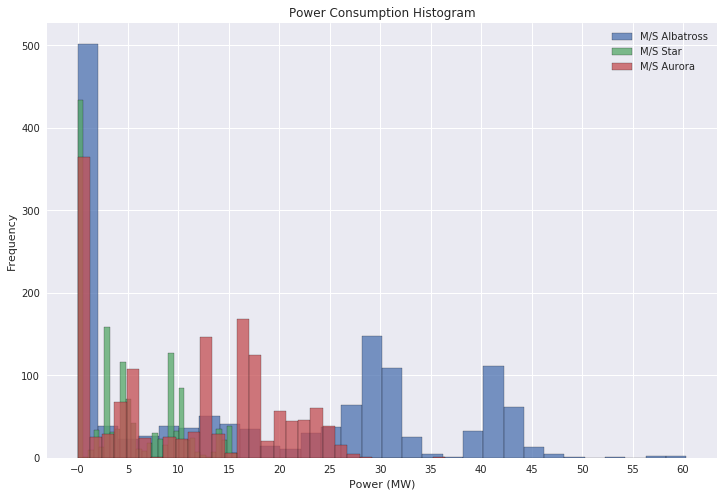

In [22]:
loc = ticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
fig, ax = plt.subplots()
for name, group in group_by_vessel:
    group['Power (MW)'].hist(label=name, alpha=.75, ax=ax, 
                             edgecolor='black', figsize=(12, 8),bins=30)
ax.legend()
ax.set_xlabel('Power (MW)')
ax.set_ylabel('Frequency')
ax.set_xticks(np.arange(min(data['Power (MW)']), max(data['Power (MW)'])+1, 5.0))
# ax.xaxis.set_major_locator(loc)
plt.title('Power Consumption Histogram')

### Daily, weekly and monthly
**To see mean power consumption in different time intervals**

#### Daily

In [23]:
power_daily = power_hourly.resample('D').mean()

Text(0.2,0.9,'Max power consumption:')

Text(0.2,0.85,'M/S Albatross: 17.343MW (2018-05-31)')

Text(0.2,0.8,'M/S Star: 5.020MW (2018-06-24)')

Text(0.2,0.75,'M/S Aurora: 10.831MW (2018-05-04)')

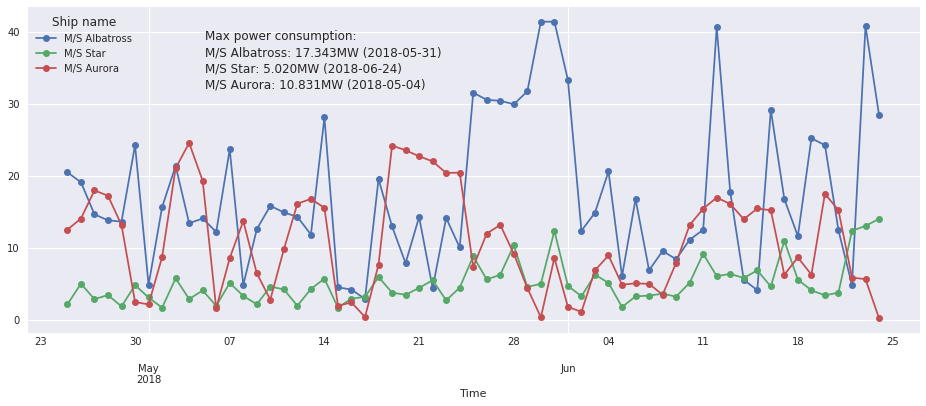

In [24]:
fig, ax = plt.subplots()
power_daily[vessel_name].plot(ax=ax, figsize=(16,6), marker='o')
plt.gca()
ax.text(0.2,0.9,'Max power consumption:', transform=ax.transAxes)
for i in range(len(vessel_name)):
    ax.text(0.2,0.85-0.05*i,'{}: {:.3f}MW ({})'
            .format(vessel_name[i],power_daily.mean()[vessel_name[i]].max(), 
            power_daily[vessel_name[i]].idxmax().date()),
            transform=ax.transAxes)

Text(0.5,1,'M/S Albatross')

Text(0.5,0,'')

[]

Text(0.5,1,'M/S Star')

Text(0.5,0,'')

[]

Text(0.5,1,'M/S Aurora')

Text(0.5,0.98,'Power Consumption (Hourly and Daily)')

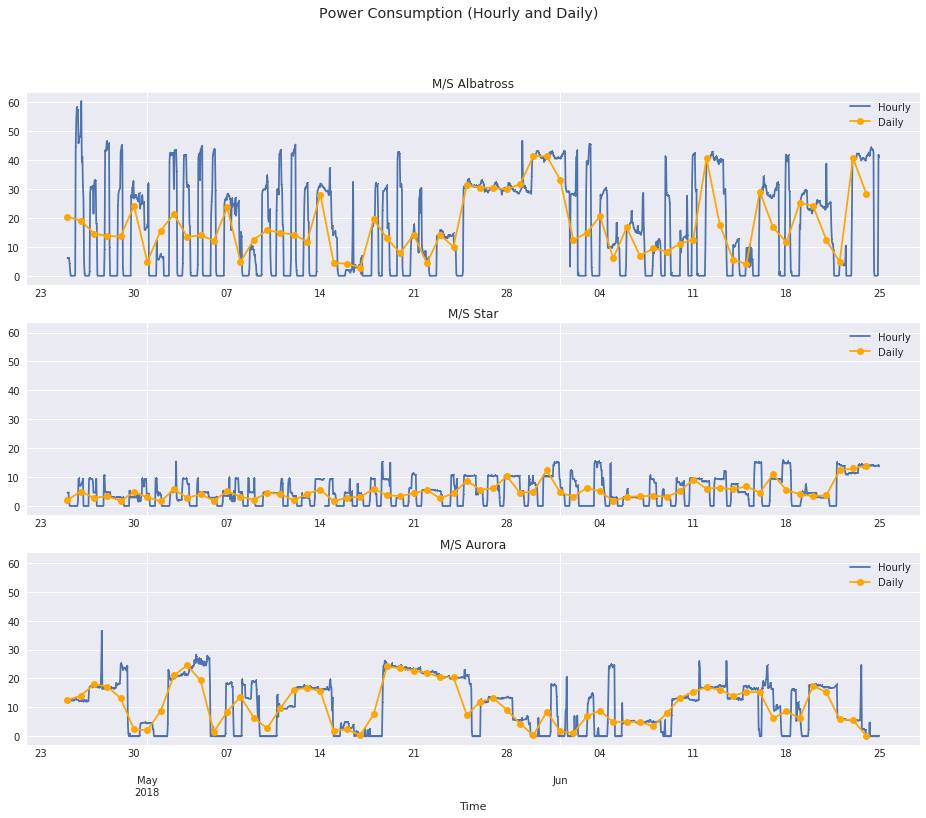

In [25]:
# Draw hourly and daily together
fig, axes = plt.subplots(len(vessel_name),1,sharey=True)
for name, ax in zip(vessel_name, axes):
    power_hourly[name].plot(marker=',', alpha=1.0, ax=ax,label='Hourly',
                               figsize=(14, 12))
    power_daily[name].plot(marker='o',figsize=(16, 12),ax=ax,color='orange',label='Daily')
    ax.legend()
    ax.set_title(name)
    if ax != axes[-1]:
        ax.set_xlabel('')
        ax.set_xticklabels([])

fig.suptitle('Power Consumption (Hourly and Daily)')
plt.savefig('hourly_daily_power.png')

[]

Text(0.5,1,'M/S Albatross')

Text(0.5,0,'')

[]

Text(0.5,1,'M/S Star')

Text(0.5,0,'')

[]

Text(0.5,1,'M/S Aurora')

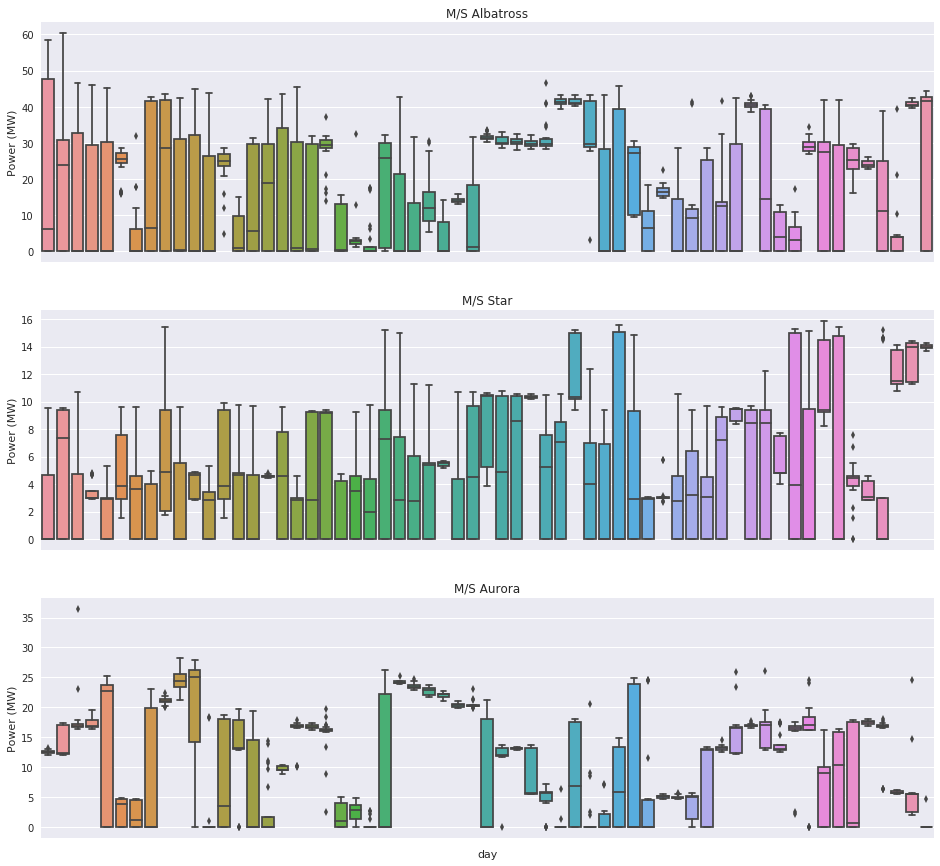

In [25]:
# Boxplot by days
fig, axes = plt.subplots(3,1,figsize=(16,15))
for i in range(len(vessel_name)):
    sns.boxplot(x="day", y="Power (MW)", 
                data=data[data['Ship name']==vessel_name[i]], ax=axes[i])
    axes[i].set_xticklabels([])
    axes[i].set_title(vessel_name[i])
    if axes[i] != axes[-1]:
        axes[i].set_xlabel('')

#### Weekly

In [26]:
power_weekly = power_hourly.resample('W').mean()
power_weekly['week'] = power_weekly.index.to_period('W')
power_weekly

Ship name,M/S Albatross,M/S Aurora,M/S Star,week
Time,,,,
2018-04-29,16.313725,14.963192,3.035167,2018-04-23/2018-04-29
2018-05-06,15.092393,11.379208,3.435107,2018-04-30/2018-05-06
2018-05-13,13.969649,10.580423,3.646605,2018-05-07/2018-05-13
2018-05-20,11.415542,10.890163,3.777557,2018-05-14/2018-05-20
2018-05-27,19.315625,16.840631,5.369649,2018-05-21/2018-05-27
2018-06-03,29.266851,4.585405,6.618024,2018-05-28/2018-06-03
2018-06-10,11.317923,6.892298,3.615339,2018-06-04/2018-06-10
2018-06-17,18.038113,14.173875,7.098411,2018-06-11/2018-06-17
2018-06-24,21.059244,8.457357,7.975162,2018-06-18/2018-06-24


[]

Text(0.5,0,'')

Text(0.5,1,'Power Consumption Boxplot by Week')

Text(0.5,1,'Mean Power Consumption (Weekly)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

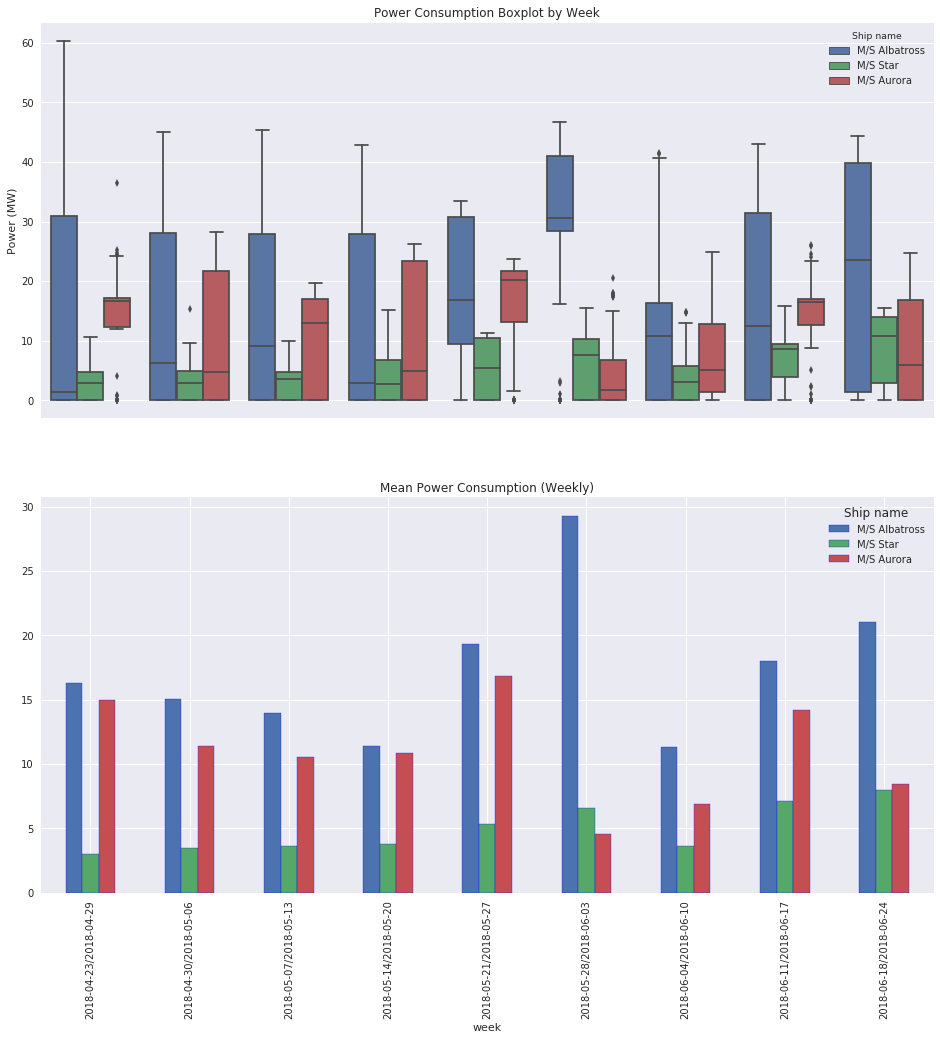

In [28]:
fig, axes = plt.subplots(2,1,figsize=(16,16))
sns.boxplot(x='week',y='Power (MW)',hue='Ship name',data=data,ax=axes[0])
axes[0].set_xticklabels([])
axes[0].set_xlabel('')
axes[0].set_title('Power Consumption Boxplot by Week')

power_weekly.plot(x='week',y=vessel_name,kind='bar',ax=axes[1],edgecolor='b')
axes[1].set_title('Mean Power Consumption (Weekly)')
plt.xticks(rotation='vertical')
plt.savefig('Weekly power.png')

In [ ]:
# Boxplot by week
# fig, axes = plt.subplots(3,1,figsize=(16,15))
# for i in range(len(vessel_name)):
#     sns.boxplot(x="week", y="Power (MW)", 
#                 data=data[data['Ship name']==vessel_name[i]], ax=axes[i])
#     axes[i].set_title(vessel_name[i])
#     if axes[i] != axes[-1]:
#         axes[i].set_xticklabels([])
#         axes[i].set_xlabel('')
# plt.xticks(rotation='vertical')

#### Monthly

In [29]:
power_monthly = power_hourly.resample('M').mean()
# power_monthly['month'] = data.index.to_period('M').unique()
power_monthly['month'] = power_monthly.index.month
power_monthly

Ship name,M/S Albatross,M/S Aurora,M/S Star,month
Time,,,,
2018-04-30,17.633778,12.878354,3.326215,4
2018-05-31,17.377790,11.866887,4.549912,5
2018-06-30,17.224243,9.014552,6.037972,6


[]

Text(0.5,0,'')

Text(0.5,1,'Power Consumption Boxplot by Month')

Text(0.5,1,'Mean Power Consumption (Monthly)')

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

Text(0.5,0,'Month')

Text(0,0.5,'Mean Power Consumption')

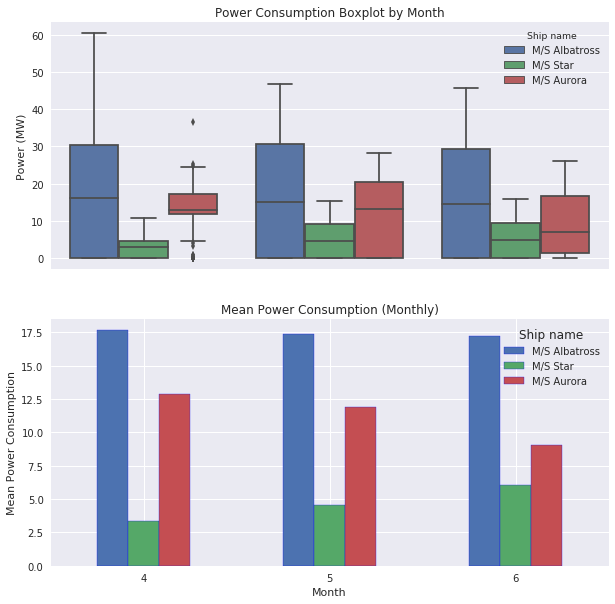

In [30]:
fig, axes = plt.subplots(2,1,figsize=(10,10))
sns.boxplot(x='month',y='Power (MW)',hue='Ship name',data=data,ax=axes[0])
axes[0].set_xticklabels([])
axes[0].set_xlabel('')
axes[0].set_title('Power Consumption Boxplot by Month')

power_monthly.plot(x='month',y=vessel_name,kind='bar',ax=axes[1],edgecolor='b')
axes[1].set_title('Mean Power Consumption (Monthly)')
plt.xticks(rotation='horizontal')
# plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1),
#           ncol=1, fancybox=True, shadow=True)
plt.xlabel('Month')
plt.ylabel('Mean Power Consumption')
plt.savefig('Monthly power.png')

In [ ]:
# power_monthly.plot(x='month',y=vessel_name,kind='bar',edgecolor='b',figsize=(8,6))
# plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1),
#           ncol=1, fancybox=True, shadow=True)
# plt.xticks(rotation='horizontal')
# plt.xlabel('Month')
# plt.ylabel('Mean Power Consumption')

Text(0.5,1,'Hourly')

Text(0,0.5,'Power (MW)')

Text(0.5,1,'Daily')

Text(0.5,0.98,'(Mean) Power Consumption (hourly and daily)')

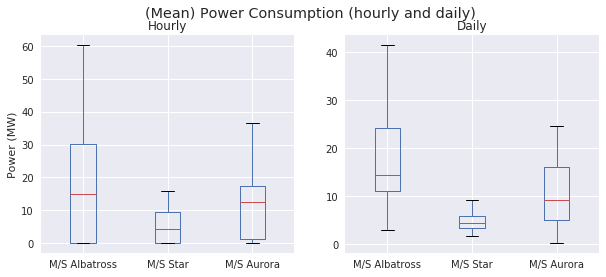

In [46]:
# Boxplots (Draw weekly and monthly together)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
colors = ['pink', 'lightblue', 'lightgreen']
power_hourly[vessel_name].boxplot(ax=axes[0])
axes[0].set_title('Hourly')
axes[0].set_ylabel('Power (MW)')
power_daily[vessel_name].boxplot(ax=axes[1])
axes[1].set_title('Daily')
plt.suptitle('(Mean) Power Consumption (hourly and daily)')

In [ ]:
# Draw weekly and monthly together
# fig, axes = plt.subplots(1, 2, figsize=(20, 8))
# power_weekly.plot(x='week',y=vessel_name,kind='bar',ax=axes[0])
# axes[0].set_ylabel('Mean Power Consumption')
# power_monthly.plot(x=power_monthly.index.month,y=vessel_name,kind='bar',ax=axes[1])
# # axes[1].legend(loc='upper right', bbox_to_anchor=(1.3, 1),
# #           ncol=1, fancybox=True, shadow=True)
# axes[1].legend(bbox_to_anchor=(0.8,1))
# plt.xticks(rotation='horizontal')
# axes[1].set_xlabel('Month')
# plt.suptitle('Mean Power Consumption (Weekly and Monthly)')

<b>
The monthly power consumption: 

Albratross 

Aurora shows an decreasing trend,

Star shows an increasing trend
</b>

### Environment Conditions

In [31]:
data.columns.values

array(['Stabilizers (boolean)', 'Current (nm/h)', 'Speed (nm/h)',
       'Power (MW)', 'Wind speed (m/s)', 'Sea temperature (Celsius)',
       'Ship name', 'day', 'week', 'month'], dtype=object)

In [32]:
env_conditions = ['Current (nm/h)', 'Wind speed (m/s)', 'Sea temperature (Celsius)']

Text(0.5,1,'Current (nm/h)')

[]

[]

Text(0.5,0,'Time')

[]

Text(0.5,1,'Wind speed (m/s)')

[]

[]

Text(0.5,0,'Time')

[]

Text(0.5,1,'Sea temperature (Celsius)')

[]

[]

Text(0.5,0,'Time')

[]

Text(0.5,0.98,'Environment Conditions')

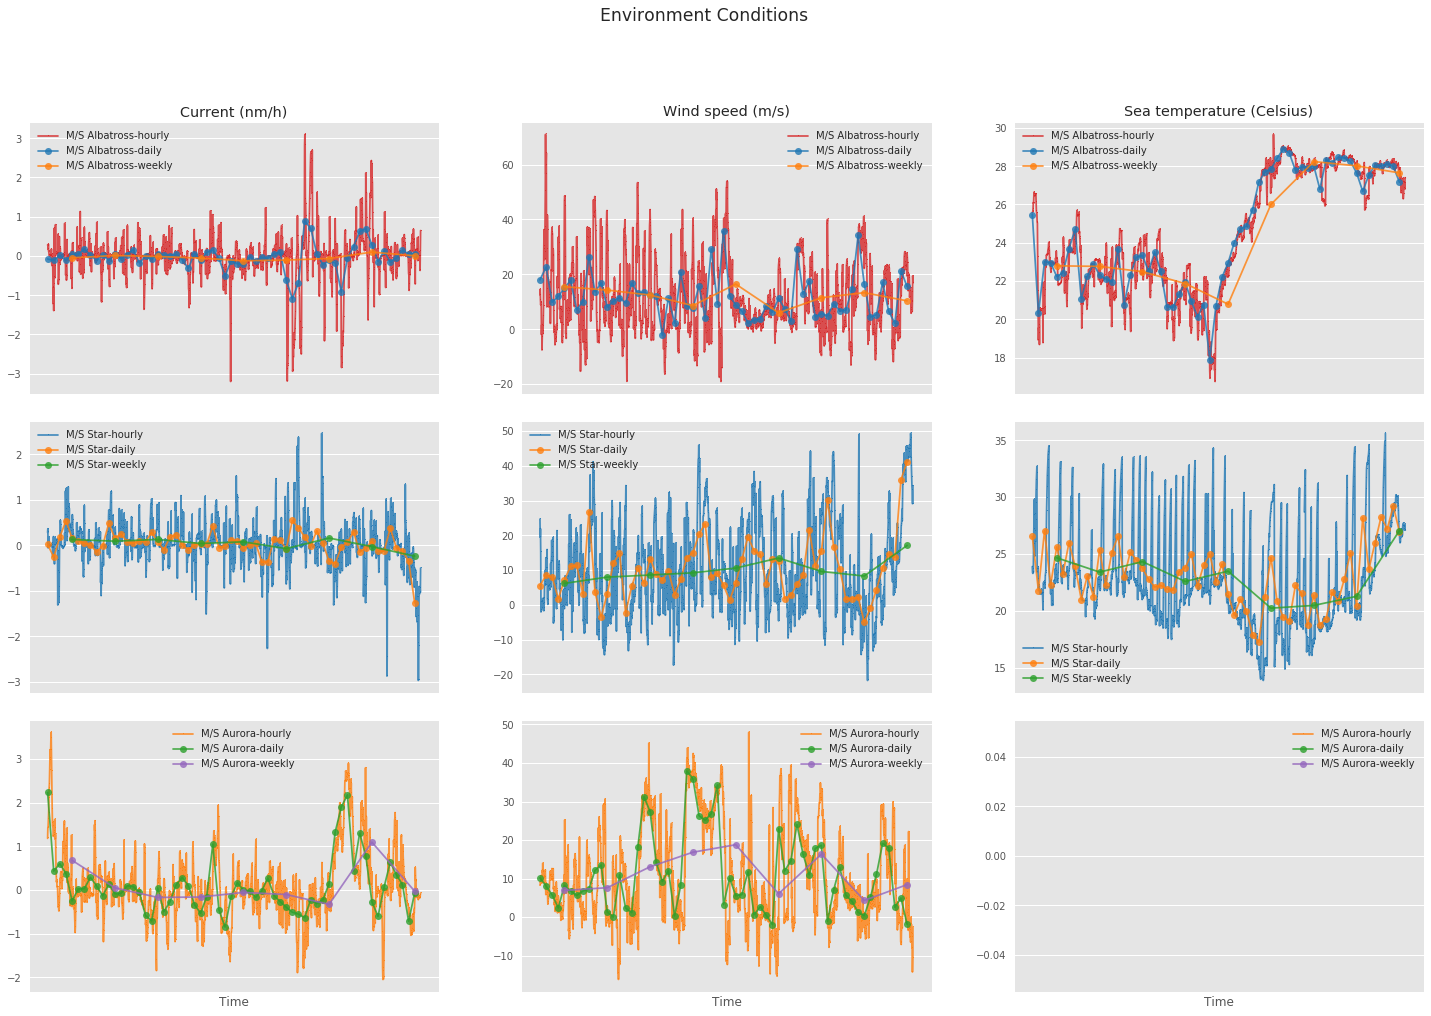

In [33]:
plt.style.use('ggplot')
import matplotlib.gridspec as gridspec

colors = ['tab:red','tab:blue','tab:orange','tab:green','tab:purple']
fig = plt.figure(figsize=(25, 16))
outer = gridspec.GridSpec(1, len(env_conditions), wspace=0.2, hspace=0.2)

for i in range(len(env_conditions)):
    inner = gridspec.GridSpecFromSubplotSpec(len(vessel_name), 1,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    for j in range(len(vessel_name)):
        ax = plt.Subplot(fig, inner[j])
        ax.plot(data[data['Ship name']==vessel_name[j]][env_conditions[i]],
                    marker=',',label=vessel_name[j]+'-'+'hourly',color=colors[j],alpha=0.8)
        ax.plot(data[data['Ship name']==vessel_name[j]][env_conditions[i]].resample('D').mean(),
                    marker='o',label=vessel_name[j]+'-'+'daily',color=colors[j+1],alpha=0.8)
        ax.plot(data[data['Ship name']==vessel_name[j]][env_conditions[i]].resample('W').mean(),
                    marker='o',label=vessel_name[j]+'-'+'weekly',color=colors[j+2],alpha=0.8)
        if j == 0:
            ax.set_title(env_conditions[i])
        if j == len(vessel_name)-1:
            ax.set_xlabel('Time')
        ax.set_xticks([])
        fig.add_subplot(ax)
        ax.legend()
# fig.show()
plt.suptitle('Environment Conditions',size='xx-large') 

In [50]:
print('std:')
for i in env_conditions:
    print(i)
    for j in vessel_name:
        print(" {}: {:.3f}".format(j, data[data['Ship name']==j][i].std()))
    print('*'*80)

std:
Current (nm/h)
 M/S Albatross: 0.603
 M/S Star: 0.479
 M/S Aurora: 0.770
********************************************************************************
Wind speed (m/s)
 M/S Albatross: 13.277
 M/S Star: 13.159
 M/S Aurora: 12.473
********************************************************************************
Sea temperature (Celsius)
 M/S Albatross: 3.065
 M/S Star: 4.286
 M/S Aurora: nan
********************************************************************************


Text(0.5,0.98,'Environment Condition (Continuous) Distribution')

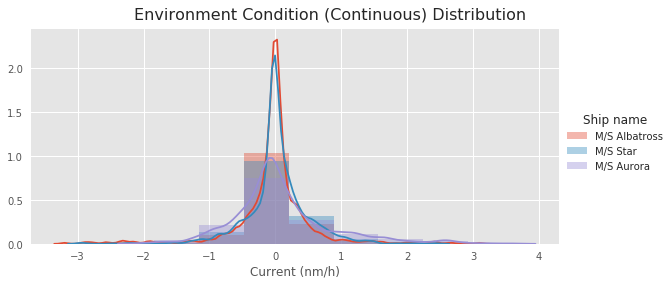

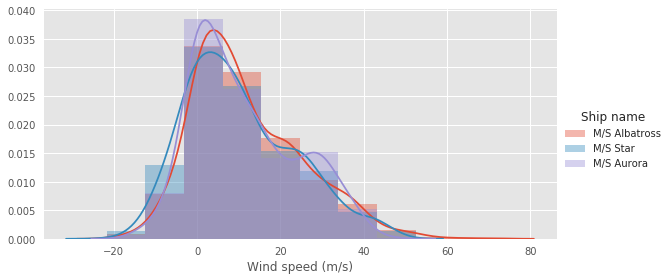

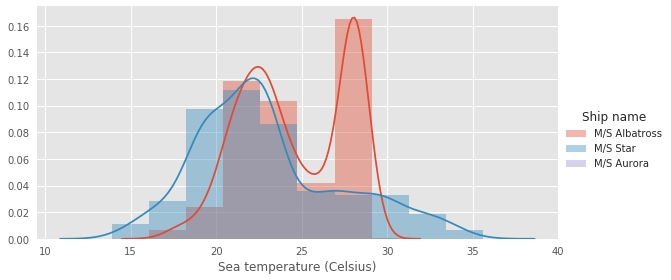

In [35]:
for i in range(len(env_conditions)):
    _, bins = np.histogram(data[env_conditions[i]].dropna())
    plot = sns.FacetGrid(data, hue="Ship name",size=4, aspect=2)
    plot = plot.map(sns.distplot, env_conditions[i], bins=bins)
    plot.add_legend()
    if i == 0:
        plot.fig.subplots_adjust(top=0.9)
        plot.fig.suptitle('Environment Condition (Continuous) Distribution', fontsize=16)
#     plot = sns.distplot(data[env_conditions[i]].dropna(),hue='Ship name', ax=axes[i])
plt.savefig('env_dist.png')

In [ ]:
# Drop the null values of power (target)
data.dropna(subset=['Power (MW)'],inplace=True)

# Only 16 speed points missing, drop those rows.
data.dropna(subset=['Speed (nm/h)'],inplace=True)

In [36]:
# Stabilizers
# Aurora has no Stabilizers data
vessel1 = data[data['Ship name'] == 'M/S Albatross'].copy(deep=True)
vessel2 = data[data['Ship name'] == 'M/S Star'].copy(deep=True)
# vessel1['Stabilizers (boolean)'] = vessel1['Stabilizers (boolean)'].astype('bool')
# vessel2['Stabilizers (boolean)'] = vessel2['Stabilizers (boolean)'].astype('bool')
vessel1.head(3)
vessel2.head(3)

,Stabilizers (boolean),Current (nm/h),Speed (nm/h),Power (MW),Wind speed (m/s),Sea temperature (Celsius),Ship name,day,week,month
Time,,,,,,,,,,
2018-04-25 00:00:00,0.0,0.281,11.019,6.096,12.593,25.57,M/S Albatross,2018-04-25,2018-04-23/2018-04-29,4
2018-04-25 01:00:00,0.0,0.263,11.137,6.058,14.559,25.60,M/S Albatross,2018-04-25,2018-04-23/2018-04-29,4
2018-04-25 02:00:00,0.0,0.167,11.133,6.074,10.717,25.65,M/S Albatross,2018-04-25,2018-04-23/2018-04-29,4


,Stabilizers (boolean),Current (nm/h),Speed (nm/h),Power (MW),Wind speed (m/s),Sea temperature (Celsius),Ship name,day,week,month
Time,,,,,,,,,,
2018-04-25 00:00:00,1.0,0.284,9.916,4.662,24.663,23.9,M/S Star,2018-04-25,2018-04-23/2018-04-29,4
2018-04-25 01:00:00,0.0,0.364,9.636,4.627,19.462,23.4,M/S Star,2018-04-25,2018-04-23/2018-04-29,4
2018-04-25 02:00:00,0.0,-0.057,9.757,4.628,21.888,23.3,M/S Star,2018-04-25,2018-04-23/2018-04-29,4


Text(0.5,0.98,'Stabilizers')

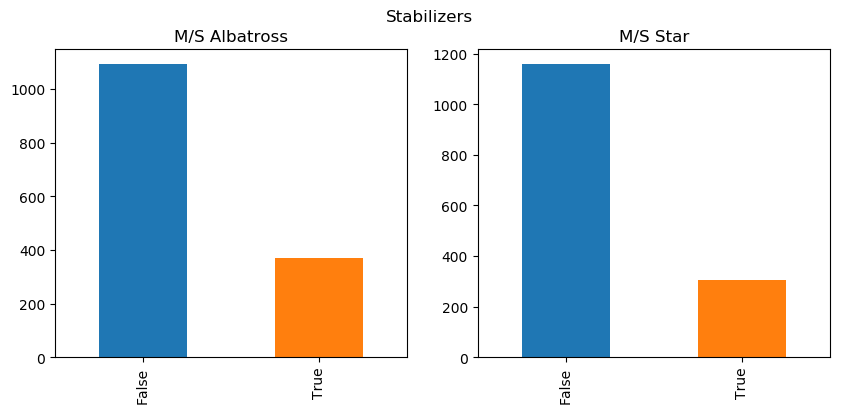

In [37]:
plt.style.use('default')
fig, axes = plt.subplots(1,2,figsize=(10,4))
fig.suptitle('Stabilizers')
vessel1['Stabilizers (boolean)'].astype('bool').value_counts().plot(kind='bar',ax=axes[0],title=vessel1['Ship name'][0])
vessel2['Stabilizers (boolean)'].astype('bool').value_counts().plot(kind='bar',ax=axes[1],title=vessel2['Ship name'][0])

### Distance sailed

#### Speed

In [38]:
speed = data.pivot(columns='Ship name', values='Speed (nm/h)')
speed.head()

Ship name,M/S Albatross,M/S Aurora,M/S Star
Time,,,
2018-04-25 00:00:00,11.019,15.320,9.916
2018-04-25 01:00:00,11.137,15.472,9.636
2018-04-25 02:00:00,11.133,15.453,9.757
2018-04-25 03:00:00,11.102,15.393,6.497
2018-04-25 04:00:00,9.384,15.543,-0.084


In [39]:
print('Hourly Speed (nm/h)')
for i in vessel_name:
    print(i)
    print("mean: {:.3f}, max: {:.3f}, min: {:.3f}, std: {:.3f}"
          .format(speed[i].mean(),speed[i].max(),speed[i].min(),speed[i].std()))

Hourly Speed (nm/h)
M/S Albatross
mean: 11.503, max: 23.407, min: -0.704, std: 8.696
M/S Star
mean: 8.279, max: 19.666, min: -1.372, std: 6.538
M/S Aurora
mean: 11.704, max: 20.870, min: -1.045, std: 7.190


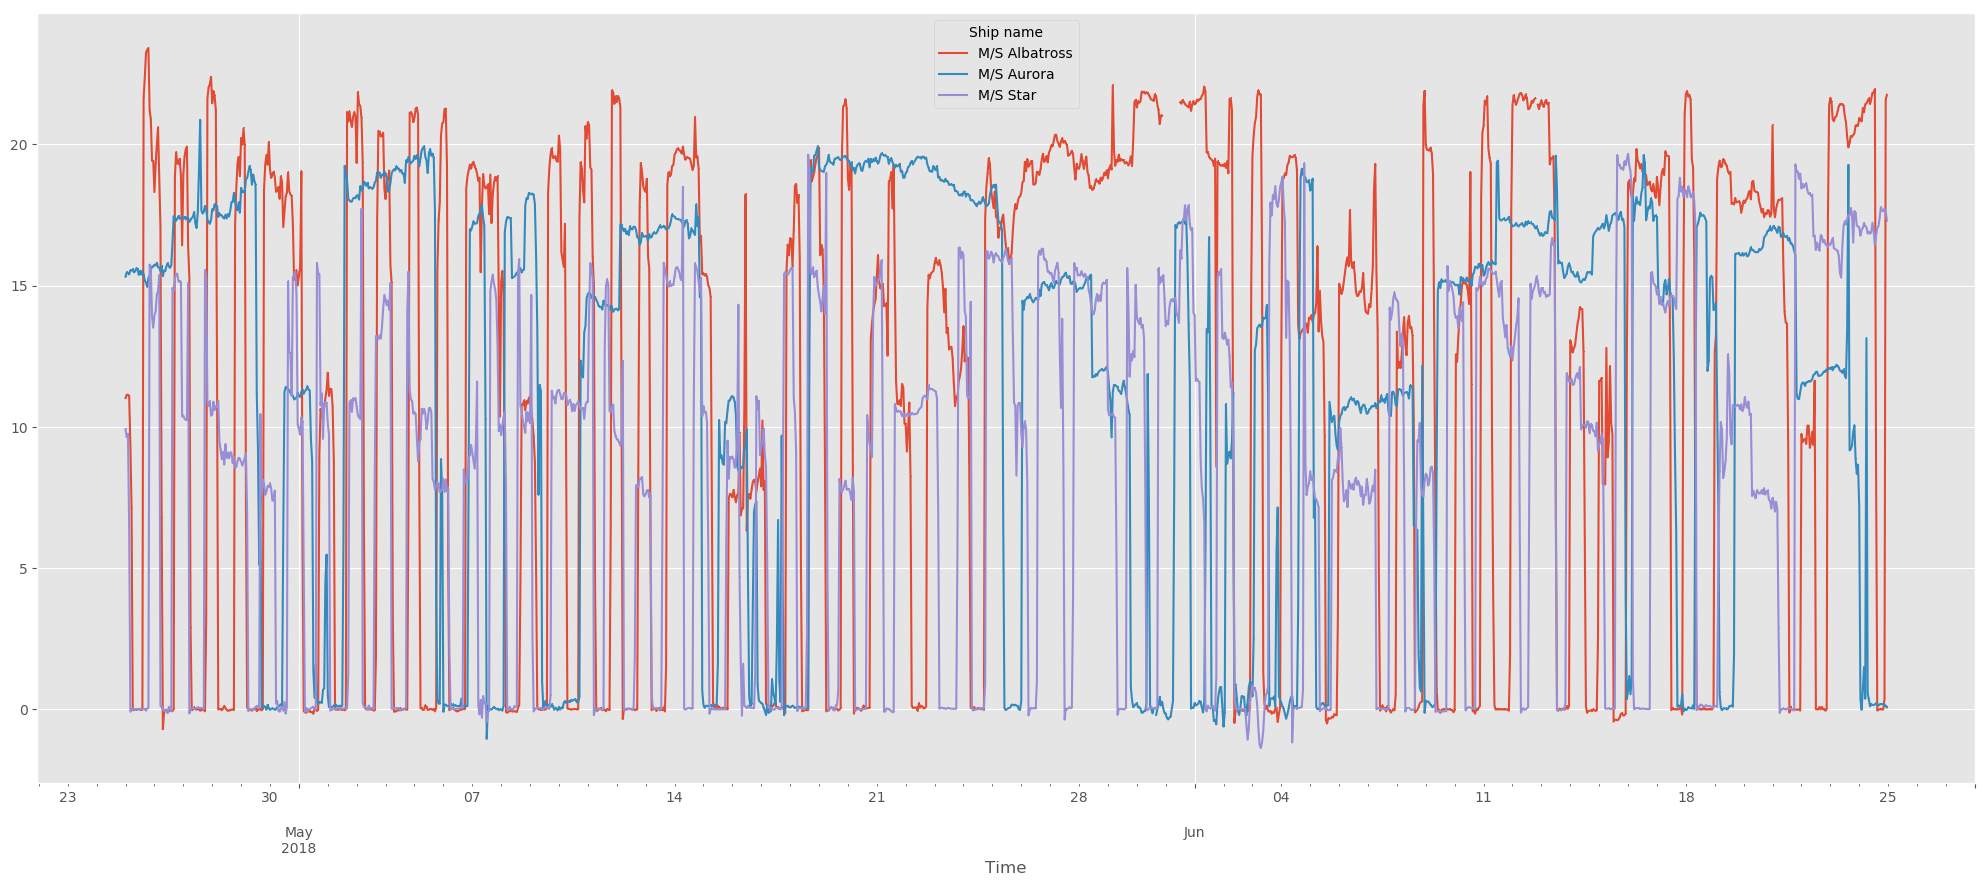

In [40]:
plt.style.use('ggplot')
speed.plot(figsize=(25,10),marker=',')

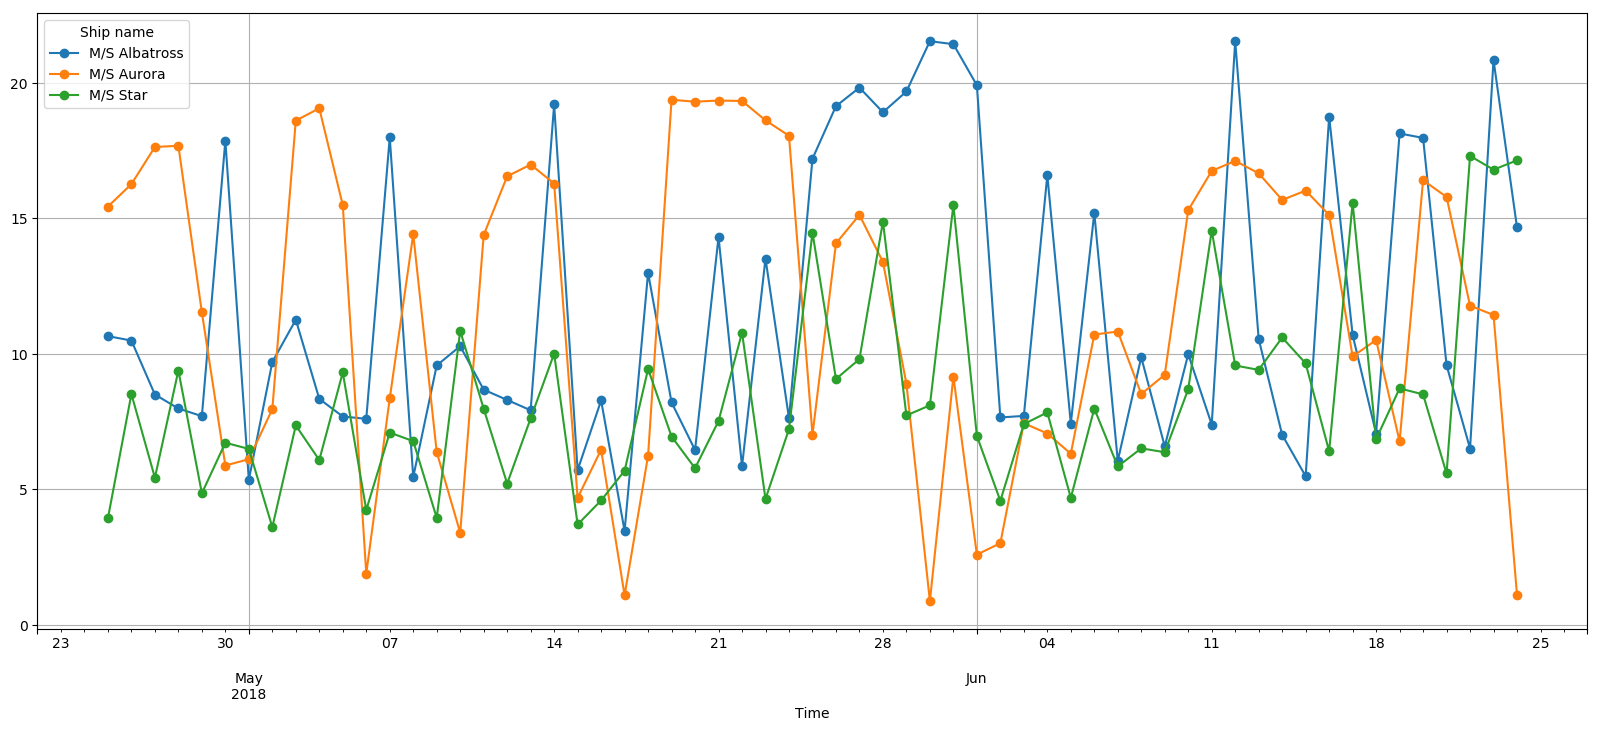

In [41]:
plt.style.use('default')
fig, ax = plt.subplots()
speed.resample('D').mean().plot(figsize=(20,8),marker='o',ax=ax)
plt.grid(True)
plt.savefig('distance_daily.png')

#### Distance

**Total Distance**

In [42]:
hourly = data.pivot(columns='Ship name', values='Speed (nm/h)')

Text(0.5,1,'Total sailed distance')

Text(0,0.5,'nm')

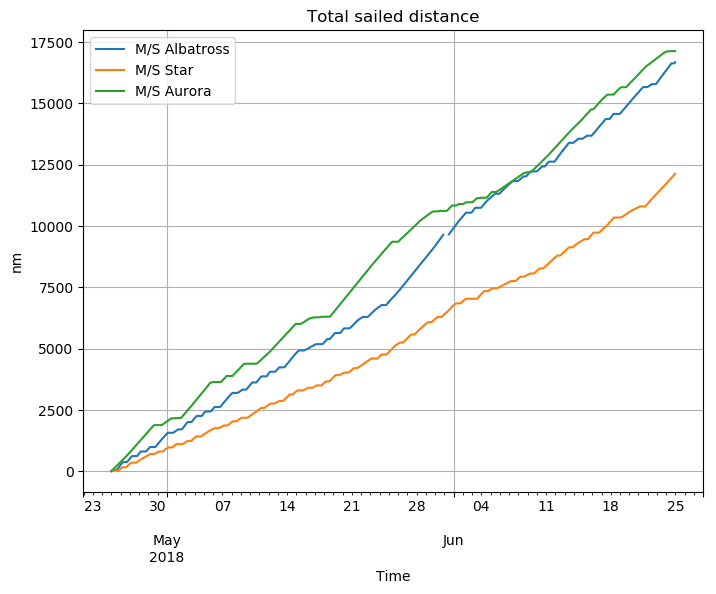

In [43]:
def calculate_distance_hourly(row, ship_name):
    # Distance in nm (speed * 1 hour)
    return row[ship_name] * 1

fig, ax = plt.subplots(figsize=(8,6))
for i in vessel_name:
    hourly[i+'_dist'] = hourly.apply(calculate_distance_hourly,ship_name=i, axis=1)
    hourly[i+'_cum_dist'] = hourly[i+'_dist'].cumsum()
    hourly.plot(y=i+'_cum_dist',ax=ax,label=i)
ax.set_title('Total sailed distance')
ax.set_ylabel('nm')
plt.grid(True)
plt.savefig('distance_total.png')

**Daily Distance**

In [15]:
daily = pd.DataFrame()
for i in vessel_name:
    daily[i+'_mean_speed'] = hourly[i].resample('D').mean()
    daily[i+'_dist'] = hourly[i+'_dist'].resample('D').sum()
    daily[i+'_cum_dist'] = hourly[i+'_cum_dist'].resample('D').last()
daily.head()

,M/S Albatross_mean_speed,M/S Albatross_dist,M/S Albatross_cum_dist,M/S Star_mean_speed,M/S Star_dist,M/S Star_cum_dist,M/S Aurora_mean_speed,M/S Aurora_dist,M/S Aurora_cum_dist
Time,,,,,,,,,
2018-04-25,10.654917,255.718,255.718,3.940833,94.580,94.580,15.434667,370.432,370.432
2018-04-26,10.491833,251.804,507.522,8.518292,204.439,299.019,16.262125,390.291,760.723
2018-04-27,8.500417,204.010,711.532,5.431542,130.357,429.376,17.632667,423.184,1183.907
2018-04-28,7.986167,191.668,903.200,9.387083,225.290,654.666,17.677000,424.248,1608.155
2018-04-29,7.703542,184.885,1088.085,4.856792,116.563,771.229,11.531250,276.750,1884.905


Text(0.5,1,'Daily Sailed Distance')

Text(0,0.5,'nm')

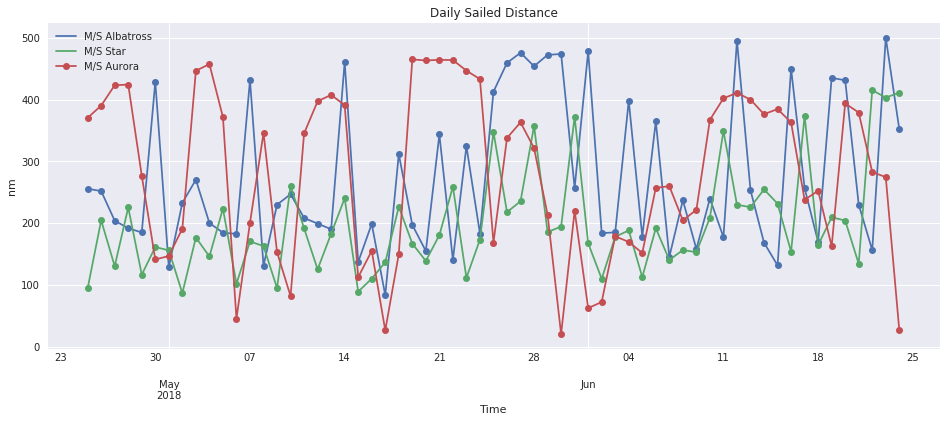

In [32]:
fig, ax = plt.subplots(figsize=(16,6))
for i in vessel_name:
    daily.plot(y=i+'_dist',ax=ax,label=i,marker='o')
ax.set_title('Daily Sailed Distance')
ax.set_ylabel('nm')
plt.grid(True)

**Weekly Distance**

In [44]:
weekly = pd.DataFrame()
for i in vessel_name:
    weekly[i+'_mean_speed'] = hourly[i].resample('W').mean()
    weekly[i+'_dist'] = hourly[i+'_dist'].resample('W').sum()
    weekly[i+'_cum_dist'] = hourly[i+'_cum_dist'].resample('W').last()
weekly['week'] = weekly.index.to_period('W')
weekly.head()

,M/S Albatross_mean_speed,M/S Albatross_dist,M/S Albatross_cum_dist,M/S Star_mean_speed,M/S Star_dist,M/S Star_cum_dist,M/S Aurora_mean_speed,M/S Aurora_dist,M/S Aurora_cum_dist,week
Time,,,,,,,,,,
2018-04-29,9.067375,1088.085,1088.085,6.426908,771.229,771.229,15.707542,1884.905,1884.905,2018-04-23/2018-04-29
2018-05-06,9.687845,1627.558,2715.643,6.261857,1051.992,1823.221,10.714714,1800.072,3684.977,2018-04-30/2018-05-06
2018-05-13,9.743232,1636.863,4352.506,7.070964,1187.922,3011.143,11.496821,1931.466,5616.443,2018-05-07/2018-05-13
2018-05-20,9.189220,1543.789,5896.295,6.596994,1108.295,4119.438,10.494054,1763.001,7379.444,2018-05-14/2018-05-20
2018-05-27,13.923702,2339.182,8235.477,9.077577,1525.033,5644.471,15.937298,2677.466,10056.910,2018-05-21/2018-05-27


Text(0.5,1,'Weekly Sailed Distance')

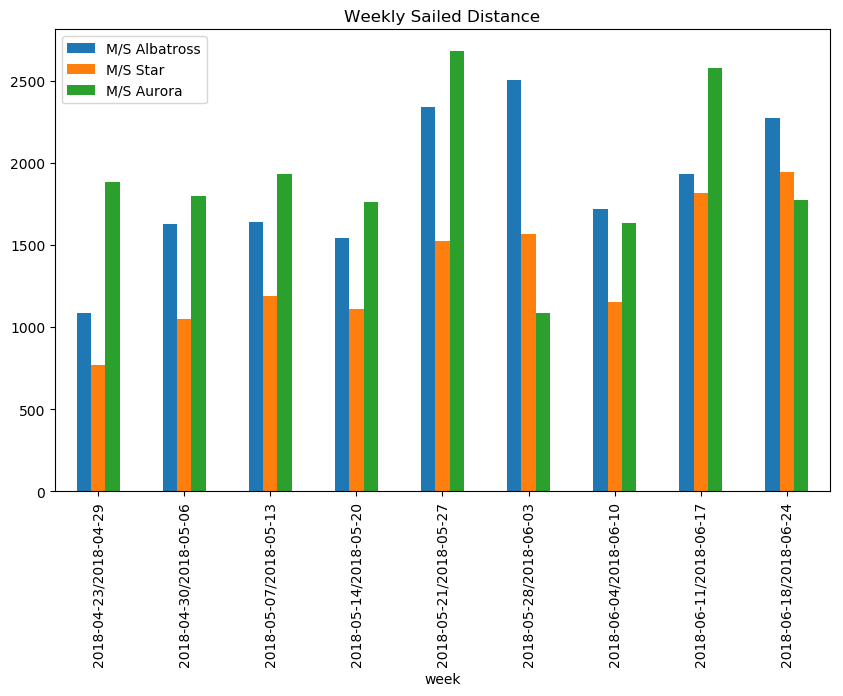

In [45]:
weekly_distance = pd.DataFrame()
for i in vessel_name:
    weekly_distance[i] = weekly[i+'_dist'].copy(deep=True)
weekly_distance['week'] = weekly_distance.index.to_period('W')
weekly_distance.plot(x='week', y=vessel_name, kind='bar',figsize=(10,6))
plt.title('Weekly Sailed Distance')
plt.savefig('weekly_power.png')

**Monthly Distance**

In [52]:
monthly = pd.DataFrame()
for i in vessel_name:
    monthly[i+'_mean_speed'] = hourly[i].resample('M').mean()
    monthly[i+'_dist'] = hourly[i+'_dist'].resample('M').sum()
    monthly[i+'_cum_dist'] = hourly[i+'_cum_dist'].resample('M').last()
monthly['month'] = monthly.index.month
monthly.head()

,M/S Albatross_mean_speed,M/S Albatross_dist,M/S Albatross_cum_dist,M/S Star_mean_speed,M/S Star_dist,M/S Star_cum_dist,M/S Aurora_mean_speed,M/S Aurora_dist,M/S Aurora_cum_dist,month
Time,,,,,,,,,,
2018-04-30,10.533507,1516.825,1516.825,6.476285,932.585,932.585,14.069924,2026.069,2026.069,4
2018-05-31,11.473666,8375.776,9892.601,7.823952,5821.020,6753.605,11.852110,8806.118,10832.187,5
2018-06-30,11.782969,6775.207,16667.808,9.316481,5366.293,12119.898,10.920620,6290.277,17122.464,6


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

Text(0.5,1,'Monthly Sailed Distance')

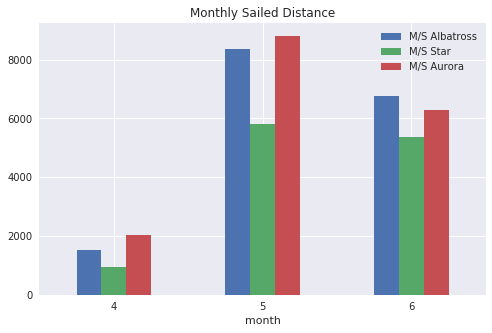

In [60]:
monthly_distance = pd.DataFrame()
for i in vessel_name:
    monthly_distance[i] = monthly[i+'_dist'].copy(deep=True)
monthly_distance['month'] = monthly_distance.index.month
monthly_distance.plot(x='month', y=vessel_name, kind='bar',figsize=(8,5))
plt.xticks(rotation='horizontal')
plt.title('Monthly Sailed Distance')

Since the data for April is only from 4.25-4.30, for June is only for 6.1-6.24,
the monthly saied distances are not complete monthly data